To use venv, 
python -m ipykernel install --user --name=yoloenv


In [1]:
#@title Import necessary packages and set correct device

import os

import numpy as np
import torch
from tqdm.auto import tqdm
# from ultralytics import YOLO
from modules.yoloclip import YoloClip
from modules.refcocog import RefCOCOg, RefCOCOgSample

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("[INFO] GPU found, using GPU.")
else:
    device = torch.device("cpu")
    print("[INFO] No GPU found, using CPU instead.")


/home/dmmp/DeepLearningLab/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] GPU found, using GPU.


In [2]:
#@title Import RefCOCOg dataset and its train/val/test splits


data_path = "/media/dmmp/vid+backup/Data/refcocog"
dataset = RefCOCOg(ds_path=data_path)

train_ds = RefCOCOg(ds_path=data_path, split='train')
val_ds = RefCOCOg(ds_path=data_path, split='val')
test_ds = RefCOCOg(ds_path=data_path, split='test')

print(f"Dataset Size: {len(dataset)}\n")
print(f"Train size: {len(train_ds)}")
print(f"Val size:   {len(val_ds)}")
print(f"Test size:  {len(test_ds)}")


Dataset Size: 49822

Train size: 42226
Val size:   2573
Test size:  5023


In [3]:
#@title Initialize YoloClip pipeline

yoloclip = YoloClip(device=device, quiet=False, dist_metric="cosine", categories=dataset.categories)


[INFO] Running YOLO on the image...



image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000409736.jpg: 480x640 3 sheeps, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


[INFO] YOLO found 3 objects
[INFO] Running CLIP on detected objects...
[INFO] Running CLIP on the prompt...
[INFO] true: sheep | predicted: person


/home/dmmp/DeepLearningLab/visual-grounding/modules/yoloclip.py:166: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  torch.tensor([gt_bbox])
/home/dmmp/DeepLearningLab/visual-grounding/modules/yoloclip.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.text(pred_bbox[0], pred_bbox[1], "predicted", color=(1, 1, 1),
/home/dmmp/DeepLearningLab/visual-grounding/modules/yoloclip.py:26: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.text(gt_bbox[0], gt_bbox[3], "true", color=(1, 1, 1),


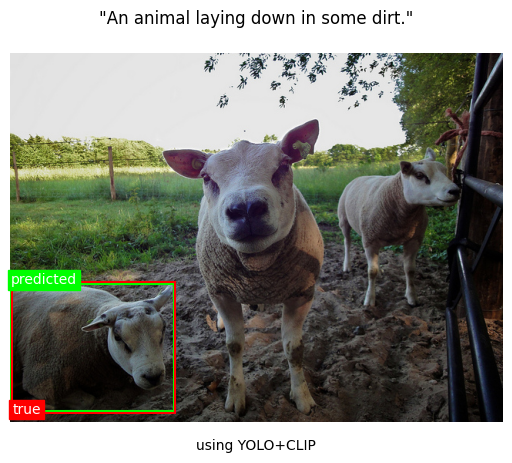


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000409736.jpg: 480x640 3 sheeps, 20.5ms
Speed: 0.5ms preprocess, 20.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


[INFO] Running YOLO on the image...
[INFO] YOLO found 3 objects
[INFO] Running CLIP on detected objects...
[INFO] Running CLIP on the prompt...
[INFO] true: sheep | predicted: person


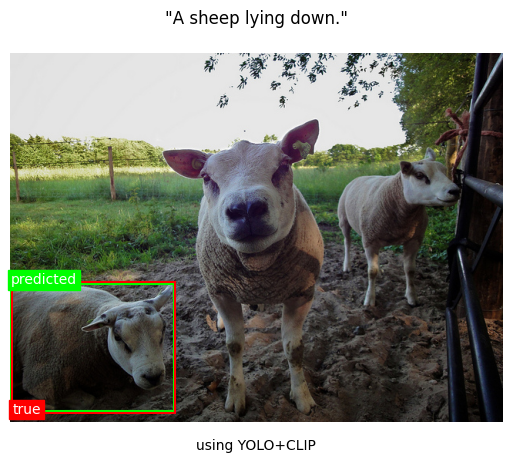

In [4]:
#@tile Test YoloClip on a random sample

%matplotlib inline

idx = np.random.randint(0, len(dataset))

sample = RefCOCOgSample(**dataset[idx])

for sentence in sample.sentences:
    yoloclip(sample, sentence, show=True)


---

In [5]:
#@title Function definition to test visual grounding with a given pipeline

def visual_grounding_test(vg_pipeline, dataset):
    scores = list()

    for sample in tqdm(dataset, desc=f"Testing on {len(dataset)} images",position=0, leave=True):

        sample = RefCOCOgSample(**sample)

        for sentence in sample.sentences:

            try:
                sc = vg_pipeline(sample, sentence, show=False)
            except ValueError:
                continue

            scores.append(sc)

    for metric in scores[0].keys():
        avg_metric = np.mean([score[metric] for score in scores])

        print("Avg. {}: {:.3f}".format(metric, avg_metric))


In [ ]:
#@title Test YoloClip on the test set

yoloclip.quiet = True

visual_grounding_test(yoloclip, test_ds)


Testing on 5023 images:   0%|                          | 0/5023 [00:00<?, ?it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380440.jpg: 384x640 2 persons, 1 backpack, 2 skiss, 19.7ms
Speed: 0.5ms preprocess, 19.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380440.jpg: 384x640 2 persons, 1 backpack, 2 skiss, 18.0ms
Speed: 0.4ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   0%|                  | 1/5023 [00:00<13:11,  6.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000419645.jpg: 448x640 3 trucks, 24.6ms
Speed: 0.4ms preprocess, 24.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000419645.jpg: 448x640 3 trucks, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.6ms post

Testing on 5023 images:   0%|                 | 15/5023 [00:02<14:18,  5.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000276740.jpg: 480x640 2 hot dogs, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000276740.jpg: 480x640 2 hot dogs, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   0%|                 | 16/5023 [00:02<13:13,  6.31it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000271641.jpg: 448x640 3 persons, 1 backpack, 2 skiss, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000271641.jpg: 448x640 3 persons, 1 backpack, 2 skiss, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.6ms 

Speed: 0.5ms preprocess, 14.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   1%|                 | 31/5023 [00:05<14:24,  5.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000108210.jpg: 448x640 4 airplanes, 7 trucks, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000108210.jpg: 448x640 4 airplanes, 7 trucks, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   1%|                 | 32/5023 [00:05<15:42,  5.30it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298160.jpg: 640x640 1 person, 2 buss, 1 horse, 19.1ms
Speed: 0.6ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_

Testing on 5023 images:   1%|▏                | 46/5023 [00:08<15:08,  5.48it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000050961.jpg: 480x640 5 ovens, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000050961.jpg: 480x640 5 ovens, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   1%|▏                | 47/5023 [00:08<14:41,  5.65it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000088653.jpg: 480x640 2 persons, 1 cell phone, 20.5ms
Speed: 0.5ms preprocess, 20.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000088653.jpg: 480x640 2 persons, 1 cell phone, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per imag

Testing on 5023 images:   1%|▏                | 61/5023 [00:11<15:15,  5.42it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000112226.jpg: 480x640 12 persons, 5 umbrellas, 1 sandwich, 4 chairs, 21.8ms
Speed: 0.8ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000112226.jpg: 480x640 12 persons, 5 umbrellas, 1 sandwich, 4 chairs, 20.0ms
Speed: 0.7ms preprocess, 20.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   1%|▏                | 62/5023 [00:11<18:44,  4.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000372319.jpg: 480x640 3 persons, 2 benchs, 1 handbag, 1 bottle, 1 cell phone, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000372319.jpg: 48

Testing on 5023 images:   2%|▎                | 77/5023 [00:13<12:11,  6.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000231878.jpg: 512x640 5 persons, 4 umbrellas, 2 handbags, 16.8ms
Speed: 0.4ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000231878.jpg: 512x640 5 persons, 4 umbrellas, 2 handbags, 16.4ms
Speed: 0.4ms preprocess, 16.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎                | 78/5023 [00:14<13:40,  6.03it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000436306.jpg: 640x640 2 persons, 3 bananas, 18.3ms
Speed: 0.5ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000436306.jpg: 640x640 2 persons, 3 bananas, 18.0ms
Speed: 0.6ms preproce

Speed: 0.4ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000285486.jpg: 480x640 5 persons, 4 cups, 5 laptops, 2 books, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎                | 92/5023 [00:16<17:02,  4.82it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298160.jpg: 640x640 1 person, 2 buss, 1 horse, 18.1ms
Speed: 0.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298160.jpg: 640x640 1 person, 2 buss, 1 horse, 17.8ms
Speed: 0.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎                | 93/5023 [00:16<15:37,  5.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/im

Speed: 0.4ms preprocess, 16.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000447297.jpg: 384x640 1 person, 3 cars, 1 motorcycle, 1 fire hydrant, 15.8ms
Speed: 0.3ms preprocess, 15.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎               | 107/5023 [00:19<12:38,  6.48it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000326357.jpg: 416x640 2 birds, 19.6ms
Speed: 0.5ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000326357.jpg: 416x640 2 birds, 20.3ms
Speed: 0.4ms preprocess, 20.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎               | 108/5023 [00:19<12:03,  6.79it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000000

Testing on 5023 images:   2%|▍               | 123/5023 [00:21<10:28,  7.80it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204759.jpg: 480x640 2 persons, 1 elephant, 1 bowl, 22.9ms
Speed: 0.6ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204759.jpg: 480x640 2 persons, 1 elephant, 1 bowl, 20.3ms
Speed: 0.5ms preprocess, 20.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▍               | 124/5023 [00:21<11:04,  7.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000053150.jpg: 448x640 2 persons, 4 cars, 1 elephant, 21.0ms
Speed: 0.4ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000053150.jpg: 448x640 2 persons, 4 cars, 1 elephant, 20.6ms
Speed: 0.4ms 

Speed: 0.5ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▍               | 138/5023 [00:24<14:48,  5.50it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000252025.jpg: 640x480 10 persons, 3 giraffes, 14.1ms
Speed: 0.4ms preprocess, 14.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000252025.jpg: 640x480 10 persons, 3 giraffes, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▍               | 139/5023 [00:24<16:00,  5.09it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000446864.jpg: 512x640 2 knifes, 3 bowls, 1 carrot, 1 chair, 3 dining tables, 16.7ms
Speed: 0.5ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/r

Speed: 0.4ms preprocess, 14.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000289211.jpg: 640x480 1 cat, 1 dog, 1 couch, 3 books, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▍               | 154/5023 [00:27<12:52,  6.30it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272255.jpg: 640x544 6 persons, 2 cars, 1 bus, 5 umbrellas, 5 handbags, 16.0ms
Speed: 0.5ms preprocess, 16.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272255.jpg: 640x544 6 persons, 2 cars, 1 bus, 5 umbrellas, 5 handbags, 15.2ms
Speed: 0.5ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▍               | 155/5023 [00:27<15:33,  5.21it/s]
image 1/

Speed: 0.7ms preprocess, 14.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000520767.jpg: 448x640 3 persons, 1 giraffe, 21.6ms
Speed: 0.4ms preprocess, 21.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000520767.jpg: 448x640 3 persons, 1 giraffe, 21.4ms
Speed: 0.4ms preprocess, 21.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▌               | 170/5023 [00:30<13:46,  5.87it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000101882.jpg: 512x640 2 persons, 2 motorcycles, 17.3ms
Speed: 0.5ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000101882.jpg: 512x640 2 persons, 2 motorcycles, 16.5ms
Speed: 0.5ms preprocess,


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000406895.jpg: 448x640 5 persons, 2 skateboards, 1 cell phone, 20.2ms
Speed: 0.6ms preprocess, 20.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▌               | 184/5023 [00:32<15:21,  5.25it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000131127.jpg: 448x640 5 persons, 2 bananas, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000131127.jpg: 448x640 5 persons, 2 bananas, 19.6ms
Speed: 0.4ms preprocess, 19.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▌               | 185/5023 [00:33<14:46,  5.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000498706.jpg: 448x640 2 persons, 2 skiss, 21.8ms
Speed: 0.4ms preprocess, 21.8ms i

Speed: 0.4ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▋               | 199/5023 [00:35<14:46,  5.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000200404.jpg: 480x640 5 persons, 4 cars, 2 trucks, 1 suitcase, 22.6ms
Speed: 0.4ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000200404.jpg: 480x640 5 persons, 4 cars, 2 trucks, 1 suitcase, 21.8ms
Speed: 0.4ms preprocess, 21.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▋               | 200/5023 [00:35<15:49,  5.08it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000256364.jpg: 480x640 2 trains, 1 traffic light, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/

Speed: 0.8ms preprocess, 21.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000416907.jpg: 480x640 2 persons, 1 bottle, 1 bowl, 1 bed, 1 toothbrush, 21.5ms
Speed: 0.6ms preprocess, 21.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▋               | 215/5023 [00:38<13:39,  5.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000078482.jpg: 480x640 3 persons, 1 tie, 1 cake, 20.2ms
Speed: 0.5ms preprocess, 20.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000078482.jpg: 480x640 3 persons, 1 tie, 1 cake, 20.9ms
Speed: 0.4ms preprocess, 20.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▋               | 216/5023 [00:38<13:30,  5.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/re

Speed: 0.4ms preprocess, 20.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▋               | 230/5023 [00:41<14:30,  5.51it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000458124.jpg: 640x480 4 persons, 1 bottle, 1 wine glass, 1 pizza, 3 chairs, 4 dining tables, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000458124.jpg: 640x480 4 persons, 1 bottle, 1 wine glass, 1 pizza, 3 chairs, 4 dining tables, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▋               | 231/5023 [00:41<16:48,  4.75it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217276.jpg: 448x640 3 persons, 1 bench, 2 umbrellas, 4 cell phones, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.8ms p


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000082228.jpg: 480x640 3 persons, 1 wine glass, 2 cups, 1 fork, 1 bowl, 1 sandwich, 1 donut, 1 dining table, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000082228.jpg: 480x640 3 persons, 1 wine glass, 2 cups, 1 fork, 1 bowl, 1 sandwich, 1 donut, 1 dining table, 20.3ms
Speed: 0.4ms preprocess, 20.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▊               | 245/5023 [00:43<17:51,  4.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000149916.jpg: 544x640 2 persons, 1 sports ball, 1 baseball glove, 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000149916.jpg: 544x640 2 person


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000048267.jpg: 448x640 16 persons, 12 wine glasss, 2 cups, 1 knife, 1 cake, 9 chairs, 2 dining tables, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▊               | 260/5023 [00:46<22:23,  3.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000269245.jpg: 480x640 2 motorcycles, 1 dog, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000269245.jpg: 480x640 2 motorcycles, 1 dog, 21.5ms
Speed: 0.4ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▊               | 261/5023 [00:46<18:55,  4.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000085939.jpg: 480x640 4 vases, 21.5ms
Spee

Testing on 5023 images:   5%|▉               | 275/5023 [00:49<14:23,  5.50it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000055733.jpg: 480x640 4 persons, 3 snowboards, 22.2ms
Speed: 0.6ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000055733.jpg: 480x640 4 persons, 3 snowboards, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▉               | 276/5023 [00:49<14:19,  5.52it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000263810.jpg: 640x384 3 persons, 1 handbag, 20 apples, 1 chair, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000263810.jpg: 640x384 3 persons, 1 handbag, 20 apples, 1 chair, 13.5ms
Spe

Testing on 5023 images:   6%|▉               | 290/5023 [00:52<15:18,  5.15it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000342807.jpg: 480x640 3 persons, 1 bench, 1 handbag, 5 wine glasss, 2 knifes, 4 chairs, 2 dining tables, 21.3ms
Speed: 0.6ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000342807.jpg: 480x640 3 persons, 1 bench, 1 handbag, 5 wine glasss, 2 knifes, 4 chairs, 2 dining tables, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   6%|▉               | 291/5023 [00:52<17:54,  4.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000234616.jpg: 448x640 3 persons, 2 baseball gloves, 20.5ms
Speed: 0.4ms preprocess, 20.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refco

Testing on 5023 images:   6%|▉               | 305/5023 [00:55<14:39,  5.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000306454.jpg: 448x640 1 knife, 2 carrots, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000306454.jpg: 448x640 1 knife, 2 carrots, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   6%|▉               | 306/5023 [00:55<13:40,  5.75it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000455791.jpg: 640x384 4 persons, 1 baseball glove, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000455791.jpg: 640x384 4 persons, 1 baseball glove, 13.1ms
Speed: 0.3ms preprocess, 13.1ms inferen

Testing on 5023 images:   6%|█               | 321/5023 [00:57<13:12,  5.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217276.jpg: 448x640 3 persons, 1 bench, 2 umbrellas, 4 cell phones, 20.8ms
Speed: 0.4ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217276.jpg: 448x640 3 persons, 1 bench, 2 umbrellas, 4 cell phones, 19.8ms
Speed: 0.4ms preprocess, 19.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   6%|█               | 322/5023 [00:58<14:02,  5.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000105666.jpg: 384x640 2 persons, 1 cup, 1 fork, 4 donuts, 2 dining tables, 16.2ms
Speed: 0.4ms preprocess, 16.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000105666.jpg: 384


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000322445.jpg: 640x480 6 persons, 2 backpacks, 1 suitcase, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█               | 337/5023 [01:00<13:40,  5.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000093176.jpg: 640x640 1 person, 1 cat, 2 beds, 18.2ms
Speed: 0.9ms preprocess, 18.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000093176.jpg: 640x640 1 person, 1 cat, 2 beds, 18.0ms
Speed: 0.9ms preprocess, 18.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█               | 338/5023 [01:00<13:05,  5.96it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000238502.jpg: 480x640 1 person, 1 bowl, 2 chairs, 2 couchs, 1 tv, 1 laptop, 1 mo

Speed: 0.5ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000005782.jpg: 480x640 2 dogs, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█               | 352/5023 [01:03<13:19,  5.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000379564.jpg: 480x640 3 cups, 2 forks, 2 knifes, 2 spoons, 2 bowls, 1 chair, 1 dining table, 19.0ms
Speed: 0.4ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000379564.jpg: 480x640 3 cups, 2 forks, 2 knifes, 2 spoons, 2 bowls, 1 chair, 1 dining table, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█               | 353/5023 [01:03<15:10,  5.

Testing on 5023 images:   7%|█▏              | 367/5023 [01:06<12:26,  6.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000114202.jpg: 640x480 2 giraffes, 15.4ms
Speed: 0.7ms preprocess, 15.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000114202.jpg: 640x480 2 giraffes, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█▏              | 368/5023 [01:06<12:03,  6.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000364653.jpg: 448x640 2 sheeps, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000364653.jpg: 448x640 2 sheeps, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 6

Speed: 0.4ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000287507.jpg: 640x448 1 cup, 1 knife, 1 bowl, 4 sandwichs, 1 broccoli, 1 dining table, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▏              | 383/5023 [01:08<18:26,  4.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000273362.jpg: 640x320 3 persons, 1 frisbee, 13.0ms
Speed: 0.4ms preprocess, 13.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000273362.jpg: 640x320 3 persons, 1 frisbee, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▏              | 384/5023 [01:09<16:10,  4.78it/s]
image 1/1 /media/dmmp/vid+backup/

Speed: 0.5ms preprocess, 17.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000554168.jpg: 512x640 3 zebras, 3 giraffes, 17.4ms
Speed: 0.5ms preprocess, 17.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▎              | 398/5023 [01:11<13:22,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197503.jpg: 480x640 5 persons, 1 cup, 11 chairs, 2 tvs, 2 remotes, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197503.jpg: 480x640 5 persons, 1 cup, 11 chairs, 2 tvs, 2 remotes, 20.6ms
Speed: 0.5ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▎              | 399/5023 [01:12<16:36,  4.64it/s]
image 1/1 /media/dmmp/vid+


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000162645.jpg: 640x640 4 persons, 3 forks, 4 pizzas, 1 chair, 1 dining table, 18.1ms
Speed: 0.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▎              | 413/5023 [01:14<14:13,  5.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000011697.jpg: 640x480 1 person, 4 cars, 1 truck, 15.0ms
Speed: 0.4ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000011697.jpg: 640x480 1 person, 4 cars, 1 truck, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▎              | 414/5023 [01:14<13:22,  5.75it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000121445.jpg: 480x640 11 persons, 2 benchs, 1 baseball ba

Speed: 0.7ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000260448.jpg: 480x640 4 persons, 1 backpack, 1 handbag, 4 bottles, 2 wine glasss, 1 chair, 1 bed, 22.0ms
Speed: 0.7ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▎              | 430/5023 [01:17<15:11,  5.04it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000456176.jpg: 512x640 1 dog, 3 cows, 17.2ms
Speed: 0.5ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000456176.jpg: 512x640 1 dog, 3 cows, 17.4ms
Speed: 0.5ms preprocess, 17.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▎              | 431/5023 [01:17<13:58,  5.48it/s]
image 1/1 /media/dmmp/vid+backup/Dat

Testing on 5023 images:   9%|█▍              | 445/5023 [01:20<16:00,  4.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000566968.jpg: 480x640 2 spoons, 3 bowls, 2 pizzas, 1 dining table, 21.4ms
Speed: 0.4ms preprocess, 21.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000566968.jpg: 480x640 2 spoons, 3 bowls, 2 pizzas, 1 dining table, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▍              | 446/5023 [01:20<15:55,  4.79it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366795.jpg: 480x640 1 person, 1 handbag, 1 banana, 20.9ms
Speed: 0.4ms preprocess, 20.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000274139.jpg: 640x448 1 dog, 13.9ms
Speed: 0.

Testing on 5023 images:   9%|█▍              | 461/5023 [01:22<12:51,  5.91it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000400740.jpg: 480x640 2 persons, 2 buss, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000400740.jpg: 480x640 2 persons, 2 buss, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▍              | 462/5023 [01:23<12:22,  6.14it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000416612.jpg: 640x448 2 persons, 1 tie, 2 cakes, 1 dining table, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000416612.jpg: 640x448 2 persons, 1 tie, 2 cakes, 1 dining table, 14.8ms
Speed: 0.5ms 

Speed: 0.4ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000148937.jpg: 640x448 3 persons, 1 tie, 1 cup, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▌              | 477/5023 [01:26<12:58,  5.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442062.jpg: 480x640 3 chairs, 4 teddy bears, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442062.jpg: 480x640 3 chairs, 4 teddy bears, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▌              | 478/5023 [01:26<13:09,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train201

Speed: 0.7ms preprocess, 14.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▌              | 492/5023 [01:28<11:47,  6.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000236260.jpg: 640x448 3 persons, 1 umbrella, 1 bottle, 1 knife, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000236260.jpg: 640x448 3 persons, 1 umbrella, 1 bottle, 1 knife, 14.7ms
Speed: 0.4ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▌              | 493/5023 [01:29<12:06,  6.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000503777.jpg: 448x640 1 chair, 2 couchs, 3 potted plants, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/

Speed: 0.4ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000274499.jpg: 480x640 2 persons, 2 ties, 2 bottles, 1 cup, 1 laptop, 22.9ms
Speed: 0.4ms preprocess, 22.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▌              | 507/5023 [01:31<13:52,  5.42it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000173925.jpg: 640x320 4 persons, 1 tennis racket, 11.6ms
Speed: 0.7ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000245326.jpg: 448x640 3 persons, 3 horses, 20.1ms
Speed: 0.6ms preprocess, 20.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000245326.jpg: 448x640 3 persons, 3 horses, 20.3ms
Spe

Speed: 0.4ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▋              | 523/5023 [01:34<13:23,  5.60it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000172957.jpg: 448x640 2 persons, 1 chair, 1 laptop, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000172957.jpg: 448x640 2 persons, 1 chair, 1 laptop, 20.3ms
Speed: 0.5ms preprocess, 20.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▋              | 524/5023 [01:34<12:48,  5.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000524991.jpg: 512x640 1 truck, 3 zebras, 17.8ms
Speed: 0.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_trai

Speed: 0.4ms preprocess, 22.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000016669.jpg: 448x640 2 tvs, 1 laptop, 1 mouse, 1 keyboard, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▋              | 538/5023 [01:37<14:28,  5.16it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072947.jpg: 448x640 3 persons, 1 frisbee, 20.1ms
Speed: 0.5ms preprocess, 20.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072947.jpg: 448x640 3 persons, 1 frisbee, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▋              | 539/5023 [01:37<13:38,  5.48it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_t

Testing on 5023 images:  11%|█▊              | 553/5023 [01:40<16:00,  4.66it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000286116.jpg: 448x640 2 persons, 2 wine glasss, 2 chairs, 1 couch, 3 laptops, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000286116.jpg: 448x640 2 persons, 2 wine glasss, 2 chairs, 1 couch, 3 laptops, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▊              | 554/5023 [01:40<15:39,  4.75it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000230321.jpg: 480x640 1 bottle, 3 beds, 23.7ms
Speed: 0.4ms preprocess, 23.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000304088.jpg: 320x640 4 persons, 2 b

Speed: 0.6ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000311088.jpg: 448x640 3 persons, 3 cars, 1 truck, 1 umbrella, 1 tie, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▊              | 569/5023 [01:43<14:03,  5.28it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000555683.jpg: 480x640 2 persons, 9 sports balls, 4 tennis rackets, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▊              | 570/5023 [01:43<12:45,  5.82it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000237367.jpg: 480x640 4 persons, 1 umbrella, 3 wine glasss, 3 chairs, 2 dining tables, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.8ms postprocess per image at shape (1,

Speed: 0.4ms preprocess, 20.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000299959.jpg: 448x640 10 persons, 2 boats, 1 dog, 1 backpack, 1 chair, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▊              | 585/5023 [01:46<14:03,  5.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000215289.jpg: 480x640 3 sheeps, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000215289.jpg: 480x640 3 sheeps, 21.3ms
Speed: 0.4ms preprocess, 21.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▊              | 586/5023 [01:46<13:12,  5.60it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000

Speed: 1.2ms preprocess, 27.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442878.jpg: 576x640 3 couchs, 1 tv, 3 books, 1 vase, 25.5ms
Speed: 0.9ms preprocess, 25.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▉              | 600/5023 [01:49<16:17,  4.52it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000089208.jpg: 448x640 2 persons, 2 horses, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000089208.jpg: 448x640 2 persons, 2 horses, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▉              | 601/5023 [01:49<15:09,  4.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train201

Speed: 0.4ms preprocess, 23.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000163598.jpg: 480x640 3 persons, 1 couch, 1 dining table, 1 tv, 1 book, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▉              | 615/5023 [01:51<14:06,  5.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000453553.jpg: 640x480 3 persons, 1 cup, 2 cakes, 1 chair, 1 dining table, 1 vase, 14.9ms
Speed: 0.4ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000453553.jpg: 640x480 3 persons, 1 cup, 2 cakes, 1 chair, 1 dining table, 1 vase, 14.4ms
Speed: 0.6ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▉              | 616/50

Speed: 0.5ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 630/5023 [01:54<11:23,  6.43it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380889.jpg: 448x640 1 person, 1 tv, 1 laptop, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380889.jpg: 448x640 1 person, 1 tv, 1 laptop, 20.4ms
Speed: 0.5ms preprocess, 20.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 631/5023 [01:54<11:20,  6.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204053.jpg: 448x640 2 persons, 3 trains, 1 handbag, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO

Speed: 0.4ms preprocess, 21.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000020619.jpg: 480x640 3 bottles, 1 cup, 1 fork, 5 donuts, 3 cakes, 1 dining table, 22.7ms
Speed: 0.4ms preprocess, 22.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 646/5023 [01:57<14:58,  4.87it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000025237.jpg: 640x512 2 persons, 2 bottles, 1 sink, 2 toothbrushs, 15.1ms
Speed: 0.6ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000025237.jpg: 640x512 2 persons, 2 bottles, 1 sink, 2 toothbrushs, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 647/5023 [01:57<14:18,  5

Speed: 0.4ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 661/5023 [01:59<11:48,  6.16it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000036445.jpg: 448x640 3 donuts, 1 dining table, 21.1ms
Speed: 0.7ms preprocess, 21.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000036445.jpg: 448x640 3 donuts, 1 dining table, 19.8ms
Speed: 0.6ms preprocess, 19.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 662/5023 [02:00<11:27,  6.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000365527.jpg: 640x416 2 persons, 2 bicycles, 1 motorcycle, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images

Speed: 0.5ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000053370.jpg: 480x640 2 persons, 3 motorcycles, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██▏             | 677/5023 [02:02<13:50,  5.23it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000446661.jpg: 448x640 4 airplanes, 1 truck, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000446661.jpg: 448x640 4 airplanes, 1 truck, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██▏             | 678/5023 [02:03<13:25,  5.39it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000

Testing on 5023 images:  14%|██▏             | 691/5023 [02:05<12:31,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000502407.jpg: 480x640 4 bowls, 2 sandwichs, 4 broccolis, 3 carrots, 2 cakes, 23.7ms
Speed: 0.4ms preprocess, 23.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000502407.jpg: 480x640 4 bowls, 2 sandwichs, 4 broccolis, 3 carrots, 2 cakes, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  14%|██▏             | 692/5023 [02:05<14:27,  4.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000377456.jpg: 448x640 2 persons, 2 benchs, 2 backpacks, 1 tennis racket, 1 chair, 22.6ms
Speed: 0.7ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_

Speed: 1.2ms preprocess, 18.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  14%|██▎             | 707/5023 [02:08<13:47,  5.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000410708.jpg: 480x640 1 bottle, 3 cups, 1 fork, 2 knifes, 1 bowl, 6 donuts, 1 dining table, 23.9ms
Speed: 0.4ms preprocess, 23.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000410708.jpg: 480x640 1 bottle, 3 cups, 1 fork, 2 knifes, 1 bowl, 6 donuts, 1 dining table, 22.9ms
Speed: 0.4ms preprocess, 22.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  14%|██▎             | 708/5023 [02:09<15:09,  4.74it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000451119.jpg: 640x480 2 persons, 1 couch, 1 tv, 4 remotes, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 0.5ms postprocess pe

Testing on 5023 images:  14%|██▎             | 722/5023 [02:11<12:12,  5.87it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000160291.jpg: 608x640 5 persons, 2 skiss, 26.0ms
Speed: 0.6ms preprocess, 26.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000160291.jpg: 608x640 5 persons, 2 skiss, 25.7ms
Speed: 0.6ms preprocess, 25.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  14%|██▎             | 723/5023 [02:11<13:02,  5.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561818.jpg: 448x640 2 giraffes, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561818.jpg: 448x640 2 giraffes, 19.6ms
Speed: 0.4ms preprocess, 19.6ms inference, 0.5ms postprocess per image at

Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000133384.jpg: 480x640 2 persons, 1 bowl, 1 couch, 2 laptops, 2 remotes, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▎             | 738/5023 [02:14<12:40,  5.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000328917.jpg: 480x640 3 persons, 1 sheep, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000328917.jpg: 480x640 3 persons, 1 sheep, 23.7ms
Speed: 0.4ms preprocess, 23.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▎             | 739/5023 [02:14<12:34,  5.68it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/image

Testing on 5023 images:  15%|██▍             | 752/5023 [02:17<14:23,  4.94it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000313569.jpg: 480x640 2 persons, 1 tv, 2 remotes, 2 books, 24.1ms
Speed: 0.5ms preprocess, 24.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000313569.jpg: 480x640 2 persons, 1 tv, 2 remotes, 2 books, 22.4ms
Speed: 0.4ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▍             | 753/5023 [02:17<14:36,  4.87it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000356922.jpg: 640x480 3 persons, 1 cup, 1 dining table, 3 laptops, 1 mouse, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▍             | 754/5023 [02:17<12:45,  5.58it/s]
image 1/1 /media/dmmp/vid+backu

Testing on 5023 images:  15%|██▍             | 767/5023 [02:20<13:43,  5.17it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000425141.jpg: 640x480 1 person, 4 bottles, 2 refrigerators, 14.6ms
Speed: 0.4ms preprocess, 14.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000425141.jpg: 640x480 1 person, 4 bottles, 2 refrigerators, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▍             | 768/5023 [02:21<13:16,  5.34it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000310360.jpg: 480x640 5 persons, 1 handbag, 1 bottle, 2 wine glasss, 1 chair, 1 dining table, 3 tvs, 2 remotes, 24.1ms
Speed: 0.7ms preprocess, 24.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000

Testing on 5023 images:  16%|██▍             | 782/5023 [02:23<14:27,  4.89it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000361197.jpg: 480x640 3 cups, 1 bowl, 1 sandwich, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000361197.jpg: 480x640 3 cups, 1 bowl, 1 sandwich, 23.1ms
Speed: 0.4ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▍             | 783/5023 [02:24<14:19,  4.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000371824.jpg: 640x640 2 persons, 2 ties, 20.2ms
Speed: 0.6ms preprocess, 20.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000371824.jpg: 640x640 2 persons, 2 ties, 18.1ms
Speed: 0.6ms preprocess, 18.1ms inference, 

Testing on 5023 images:  16%|██▌             | 797/5023 [02:26<13:52,  5.08it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000024095.jpg: 480x640 1 sheep, 2 giraffes, 23.4ms
Speed: 0.7ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000024095.jpg: 480x640 1 sheep, 2 giraffes, 23.0ms
Speed: 0.7ms preprocess, 23.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▌             | 798/5023 [02:26<13:12,  5.33it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000253796.jpg: 512x640 2 birds, 2 giraffes, 17.7ms
Speed: 0.5ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000253796.jpg: 512x640 2 birds, 2 giraffes, 17.7ms
Speed: 0.5ms preprocess, 17.7ms inference, 0.5ms post


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000044298.jpg: 640x480 3 persons, 1 cup, 1 cell phone, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▌             | 813/5023 [02:29<12:00,  5.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556162.jpg: 480x640 2 persons, 5 teddy bears, 22.1ms
Speed: 0.7ms preprocess, 22.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556162.jpg: 480x640 2 persons, 5 teddy bears, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▌             | 814/5023 [02:29<12:10,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000078590.jpg: 640x480 3 wine glasss, 1 bowl, 1 pizza, 1 dining table, 15.0ms
Speed

Speed: 0.5ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000172680.jpg: 640x480 4 persons, 3 bottles, 10 knifes, 2 ovens, 1 refrigerator, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▋             | 828/5023 [02:32<15:02,  4.65it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000002448.jpg: 480x640 2 chairs, 2 potted plants, 2 microwaves, 1 oven, 1 toaster, 1 refrigerator, 1 clock, 1 vase, 22.5ms
Speed: 0.4ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000002448.jpg: 480x640 2 chairs, 2 potted plants, 2 microwaves, 1 oven, 1 toaster, 1 refrigerator, 1 clock, 1 vase, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per image at sh

Testing on 5023 images:  17%|██▋             | 841/5023 [02:35<12:34,  5.54it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000330806.jpg: 480x640 3 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000330806.jpg: 480x640 3 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▋             | 842/5023 [02:35<12:37,  5.52it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000095124.jpg: 448x640 3 persons, 1 bench, 1 umbrella, 2 handbags, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000

Speed: 0.4ms preprocess, 23.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000277418.jpg: 448x640 1 person, 1 bottle, 1 fork, 1 spoon, 1 bowl, 2 chairs, 1 dining table, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▋             | 857/5023 [02:38<13:04,  5.31it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305106.jpg: 448x640 2 persons, 2 umbrellas, 1 chair, 20.4ms
Speed: 0.4ms preprocess, 20.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305106.jpg: 448x640 2 persons, 2 umbrellas, 1 chair, 19.8ms
Speed: 0.5ms preprocess, 19.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▋             | 858/5023 [02:38<12:29,  5.56it/s]
image

Speed: 0.5ms preprocess, 14.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▊             | 871/5023 [02:41<17:25,  3.97it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000393159.jpg: 640x480 4 airplanes, 3 sinks, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000393159.jpg: 640x480 4 airplanes, 3 sinks, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▊             | 872/5023 [02:41<16:14,  4.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000106978.jpg: 480x640 2 persons, 2 umbrellas, 1 tie, 1 bottle, 2 chairs, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000303541.jpg: 640x640 2 giraffes, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  18%|██▊             | 887/5023 [02:44<11:27,  6.01it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042463.jpg: 480x640 2 persons, 7 cups, 1 spoon, 2 cakes, 1 chair, 1 dining table, 22.1ms
Speed: 0.7ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042463.jpg: 480x640 2 persons, 7 cups, 1 spoon, 2 cakes, 1 chair, 1 dining table, 22.9ms
Speed: 0.8ms preprocess, 22.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  18%|██▊             | 888/5023 [02:44<13:00,  5.30it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000165077.jpg: 480x640 2 person

Testing on 5023 images:  18%|██▊             | 902/5023 [02:47<12:41,  5.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000479707.jpg: 448x640 9 persons, 2 ties, 2 wine glasss, 4 cups, 1 bowl, 8 chairs, 6 dining tables, 1 vase, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000479707.jpg: 448x640 9 persons, 2 ties, 2 wine glasss, 4 cups, 1 bowl, 8 chairs, 6 dining tables, 1 vase, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  18%|██▉             | 903/5023 [02:47<17:50,  3.85it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000140053.jpg: 384x640 3 elephants, 16.3ms
Speed: 0.6ms preprocess, 16.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/CO

Testing on 5023 images:  18%|██▉             | 918/5023 [02:50<14:28,  4.73it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000147429.jpg: 640x448 1 person, 1 car, 2 trucks, 1 frisbee, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000147429.jpg: 640x448 1 person, 1 car, 2 trucks, 1 frisbee, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  18%|██▉             | 919/5023 [02:51<13:07,  5.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000256930.jpg: 480x640 5 vases, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000256930.jpg: 480x640 5 vases, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 

Speed: 0.4ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|██▉             | 934/5023 [02:53<12:01,  5.67it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000471900.jpg: 416x640 2 persons, 1 car, 1 backpack, 1 skis, 24.2ms
Speed: 0.4ms preprocess, 24.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000471900.jpg: 416x640 2 persons, 1 car, 1 backpack, 1 skis, 23.0ms
Speed: 0.4ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|██▉             | 935/5023 [02:53<12:13,  5.57it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000536555.jpg: 448x640 2 cats, 1 suitcase, 24.3ms
Speed: 0.6ms preprocess, 24.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog

Testing on 5023 images:  19%|███             | 949/5023 [02:56<12:49,  5.29it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000409678.jpg: 448x640 1 wine glass, 3 bowls, 7 pizzas, 1 chair, 1 dining table, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|███             | 950/5023 [02:56<11:46,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366702.jpg: 448x640 1 bottle, 3 chairs, 1 couch, 3 tvs, 2 books, 1 vase, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366702.jpg: 448x640 1 bottle, 3 chairs, 1 couch, 3 tvs, 2 books, 1 vase, 21.2ms
Speed: 0.6ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|███             | 951/5023 [02:56<13:12,  5.14i

Speed: 0.6ms preprocess, 14.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|███             | 965/5023 [02:59<15:13,  4.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000323218.jpg: 640x480 3 persons, 1 fork, 2 chairs, 2 potted plants, 1 tv, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000323218.jpg: 640x480 3 persons, 1 fork, 2 chairs, 2 potted plants, 1 tv, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|███             | 966/5023 [02:59<14:30,  4.66it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000278045.jpg: 480x640 6 zebras, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+ba

Testing on 5023 images:  20%|███             | 980/5023 [03:02<12:07,  5.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305105.jpg: 480x640 5 persons, 1 spoon, 1 bowl, 1 chair, 1 couch, 1 dining table, 1 laptop, 2 remotes, 22.8ms
Speed: 0.9ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305105.jpg: 480x640 5 persons, 1 spoon, 1 bowl, 1 chair, 1 couch, 1 dining table, 1 laptop, 2 remotes, 22.7ms
Speed: 0.9ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███             | 981/5023 [03:02<13:09,  5.12it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000300021.jpg: 480x640 1 person, 1 knife, 7 pizzas, 22.7ms
Speed: 0.6ms preprocess, 22.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcoc

Testing on 5023 images:  20%|███▏            | 995/5023 [03:05<11:34,  5.80it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000525591.jpg: 480x640 2 sheeps, 24.2ms
Speed: 0.5ms preprocess, 24.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000525591.jpg: 480x640 2 sheeps, 23.4ms
Speed: 0.5ms preprocess, 23.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███▏            | 996/5023 [03:05<11:01,  6.09it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000074127.jpg: 480x640 4 persons, 1 cup, 6 bowls, 1 banana, 1 pizza, 1 dining table, 1 oven, 1 refrigerator, 22.1ms
Speed: 0.4ms preprocess, 22.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000074127.jpg: 480x640 4 persons, 1 cup, 6 bowls, 1 banana, 1

Speed: 0.5ms preprocess, 23.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███            | 1011/5023 [03:08<15:55,  4.20it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000035265.jpg: 480x640 5 persons, 2 baseball bats, 1 baseball glove, 1 chair, 23.4ms
Speed: 0.5ms preprocess, 23.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000035265.jpg: 480x640 5 persons, 2 baseball bats, 1 baseball glove, 1 chair, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███            | 1012/5023 [03:09<15:35,  4.29it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000117772.jpg: 640x640 4 persons, 1 tie, 18.1ms
Speed: 0.6ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /med

Speed: 0.5ms preprocess, 17.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███            | 1027/5023 [03:11<12:39,  5.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000239532.jpg: 448x640 8 persons, 2 boats, 1 sports ball, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000239532.jpg: 448x640 8 persons, 2 boats, 1 sports ball, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███            | 1028/5023 [03:12<13:42,  4.85it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000007621.jpg: 448x640 10 persons, 4 cows, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/image

Speed: 0.5ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  21%|███            | 1042/5023 [03:14<12:40,  5.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000537304.jpg: 448x640 1 person, 5 bottles, 3 cups, 1 bowl, 2 pizzas, 1 oven, 1 sink, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000537304.jpg: 448x640 1 person, 5 bottles, 3 cups, 1 bowl, 2 pizzas, 1 oven, 1 sink, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  21%|███            | 1043/5023 [03:14<14:13,  4.66it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000466964.jpg: 480x640 10 persons, 1 car, 3 umbrellas, 1 handbag, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.8ms postprocess per image 

Testing on 5023 images:  21%|███▏           | 1057/5023 [03:17<12:23,  5.34it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000225477.jpg: 448x640 6 persons, 13 wine glasss, 2 cups, 4 forks, 3 knifes, 3 spoons, 1 cake, 1 dining table, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000225477.jpg: 448x640 6 persons, 13 wine glasss, 2 cups, 4 forks, 3 knifes, 3 spoons, 1 cake, 1 dining table, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  21%|███▏           | 1058/5023 [03:18<17:21,  3.81it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000454898.jpg: 416x640 6 umbrellas, 19.7ms
Speed: 0.4ms preprocess, 19.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/ima

Testing on 5023 images:  21%|███▏           | 1072/5023 [03:20<12:01,  5.48it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000398872.jpg: 640x448 2 persons, 5 bicycles, 1 bench, 1 cell phone, 14.9ms
Speed: 0.4ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000398872.jpg: 640x448 2 persons, 5 bicycles, 1 bench, 1 cell phone, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  21%|███▏           | 1073/5023 [03:20<12:00,  5.48it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042696.jpg: 480x640 4 elephants, 23.7ms
Speed: 0.4ms preprocess, 23.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042696.jpg: 480x640 4 elephants, 21.1ms
Speed: 0.5ms prepro

Speed: 0.4ms preprocess, 13.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  22%|███▏           | 1087/5023 [03:23<10:56,  6.00it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305224.jpg: 480x640 3 persons, 1 backpack, 1 handbag, 2 chairs, 3 couchs, 1 dining table, 1 laptop, 1 cell phone, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305224.jpg: 480x640 3 persons, 1 backpack, 1 handbag, 2 chairs, 3 couchs, 1 dining table, 1 laptop, 1 cell phone, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  22%|███▏           | 1088/5023 [03:23<12:54,  5.08it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000356159.jpg: 384x640 5 persons, 4 surfboards, 17.0ms
Speed: 0.4ms preprocess, 17


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000165847.jpg: 640x480 3 persons, 1 dog, 1 kite, 4 potted plants, 14.9ms
Speed: 0.6ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  22%|███▎           | 1103/5023 [03:26<12:51,  5.08it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000163054.jpg: 640x448 3 airplanes, 1 truck, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000163054.jpg: 640x448 3 airplanes, 1 truck, 14.4ms
Speed: 0.4ms preprocess, 14.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  22%|███▎           | 1104/5023 [03:27<12:13,  5.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000152238.jpg: 640x640 2 elephants, 18.4ms
Speed: 1.0ms preprocess, 18.4ms infer

Testing on 5023 images:  22%|███▎           | 1117/5023 [03:29<13:30,  4.82it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000410165.jpg: 480x640 1 person, 2 cars, 1 truck, 1 dog, 2 horses, 20.5ms
Speed: 0.5ms preprocess, 20.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000410165.jpg: 480x640 1 person, 2 cars, 1 truck, 1 dog, 2 horses, 20.9ms
Speed: 0.4ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  22%|███▎           | 1118/5023 [03:30<13:17,  4.90it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000405013.jpg: 480x640 2 persons, 1 bowl, 1 donut, 2 chairs, 1 dining table, 19.3ms
Speed: 0.4ms preprocess, 19.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000405013.jpg: 480x640 2 


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000133609.jpg: 480x640 1 car, 1 cup, 5 potted plants, 1 toilet, 19.9ms
Speed: 0.8ms preprocess, 19.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1132/5023 [03:33<14:44,  4.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000315168.jpg: 480x640 3 persons, 3 cars, 4 umbrellas, 1 handbag, 1 chair, 3 dining tables, 21.8ms
Speed: 0.8ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000315168.jpg: 480x640 3 persons, 3 cars, 4 umbrellas, 1 handbag, 1 chair, 3 dining tables, 21.4ms
Speed: 0.7ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1133/5023 [03:33<15:16,  4.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_t


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000076885.jpg: 448x640 2 persons, 2 laptops, 20.9ms
Speed: 0.5ms preprocess, 20.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1147/5023 [03:36<12:00,  5.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080826.jpg: 640x480 2 persons, 1 bottle, 3 cups, 1 bowl, 2 pizzas, 3 chairs, 2 dining tables, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080826.jpg: 640x480 2 persons, 1 bottle, 3 cups, 1 bowl, 2 pizzas, 3 chairs, 2 dining tables, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1148/5023 [03:36<13:13,  4.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_

Testing on 5023 images:  23%|███▍           | 1162/5023 [03:38<11:30,  5.60it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000544294.jpg: 448x640 4 persons, 1 bottle, 1 wine glass, 1 cup, 1 couch, 1 potted plant, 1 laptop, 1 vase, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000544294.jpg: 448x640 4 persons, 1 bottle, 1 wine glass, 1 cup, 1 couch, 1 potted plant, 1 laptop, 1 vase, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1163/5023 [03:38<12:22,  5.20it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000210604.jpg: 640x448 2 persons, 1 frisbee, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/

Speed: 0.5ms preprocess, 13.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000163054.jpg: 640x448 3 airplanes, 1 truck, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▌           | 1177/5023 [03:41<10:34,  6.06it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000401173.jpg: 448x640 2 zebras, 19.5ms
Speed: 0.7ms preprocess, 19.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000401173.jpg: 448x640 2 zebras, 20.9ms
Speed: 0.7ms preprocess, 20.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▌           | 1178/5023 [03:41<10:00,  6.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000433874.jpg: 448x640 2 per


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000482706.jpg: 544x640 2 persons, 3 toothbrushs, 22.9ms
Speed: 0.6ms preprocess, 22.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▌           | 1192/5023 [03:44<12:49,  4.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442062.jpg: 480x640 3 chairs, 4 teddy bears, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442062.jpg: 480x640 3 chairs, 4 teddy bears, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▌           | 1193/5023 [03:45<12:27,  5.12it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000564421.jpg: 640x448 3 persons, 1 tennis racket, 15 chairs, 14.0ms
Speed: 0.5ms preproces

Speed: 0.5ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▌           | 1207/5023 [03:48<13:05,  4.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000157125.jpg: 480x640 3 persons, 1 bench, 1 cell phone, 25.2ms
Speed: 0.5ms preprocess, 25.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000157125.jpg: 480x640 3 persons, 1 bench, 1 cell phone, 20.3ms
Speed: 0.5ms preprocess, 20.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▌           | 1208/5023 [03:48<12:11,  5.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000179763.jpg: 640x448 1 giraffe, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_trai

Speed: 0.7ms preprocess, 21.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▋           | 1223/5023 [03:51<11:14,  5.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000515252.jpg: 480x640 1 person, 3 buss, 1 truck, 1 horse, 21.7ms
Speed: 0.6ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000515252.jpg: 480x640 1 person, 3 buss, 1 truck, 1 horse, 21.0ms
Speed: 0.6ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▋           | 1224/5023 [03:51<11:22,  5.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000070415.jpg: 448x640 1 bottle, 3 pizzas, 1 dining table, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/D


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000452750.jpg: 448x640 4 persons, 1 knife, 1 spoon, 2 bowls, 1 cake, 1 dining table, 20.4ms
Speed: 0.7ms preprocess, 20.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  25%|███▋           | 1238/5023 [03:54<16:42,  3.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000544875.jpg: 640x480 2 toilets, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000544875.jpg: 640x480 2 toilets, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  25%|███▋           | 1239/5023 [03:54<13:47,  4.57it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042529.jpg: 544x640 10 persons, 4 cars, 1 bus, 2 traffic lights, 2 clocks, 24.5m

Testing on 5023 images:  25%|███▋           | 1253/5023 [03:57<14:20,  4.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000313071.jpg: 480x640 3 persons, 2 wine glasss, 2 cups, 1 fork, 1 knife, 1 bowl, 1 chair, 1 dining table, 1 cell phone, 20.5ms
Speed: 0.5ms preprocess, 20.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000313071.jpg: 480x640 3 persons, 2 wine glasss, 2 cups, 1 fork, 1 knife, 1 bowl, 1 chair, 1 dining table, 1 cell phone, 20.8ms
Speed: 0.7ms preprocess, 20.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  25%|███▋           | 1254/5023 [03:57<14:30,  4.33it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000295578.jpg: 480x640 3 persons, 1 baseball bat, 2 baseball gloves, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640

Speed: 0.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000572353.jpg: 512x640 2 horses, 16.5ms
Speed: 0.5ms preprocess, 16.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  25%|███▊           | 1268/5023 [04:01<11:11,  5.59it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000062131.jpg: 480x640 1 bird, 4 chairs, 1 dining table, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000295759.jpg: 480x640 7 persons, 1 car, 1 kite, 21.5ms
Speed: 0.4ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000295759.jpg: 480x640 7 persons, 1 car, 1 kite, 20.9ms
Speed: 0.5ms preprocess,

Speed: 0.8ms preprocess, 25.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▊           | 1284/5023 [04:04<11:15,  5.54it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000037682.jpg: 448x640 3 persons, 1 backpack, 2 surfboards, 20.8ms
Speed: 0.4ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000037682.jpg: 448x640 3 persons, 1 backpack, 2 surfboards, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▊           | 1285/5023 [04:04<11:02,  5.64it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000558570.jpg: 448x640 2 persons, 2 cars, 1 bench, 1 sports ball, 1 tennis racket, 20.1ms
Speed: 0.4ms preprocess, 20.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/

Speed: 0.5ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000464965.jpg: 480x640 2 persons, 1 bottle, 1 sandwich, 1 chair, 1 keyboard, 22.0ms
Speed: 0.6ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▉           | 1300/5023 [04:07<13:17,  4.67it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000566308.jpg: 640x448 2 persons, 1 bench, 1 skateboard, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000566308.jpg: 640x448 2 persons, 1 bench, 1 skateboard, 14.7ms
Speed: 0.4ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▉           | 1301/5023 [04:07<12:38,  4.91it/s]
image 1/1 /media/dmm

Speed: 0.4ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▉           | 1315/5023 [04:10<10:19,  5.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000526912.jpg: 544x640 3 persons, 3 motorcycles, 24.1ms
Speed: 1.2ms preprocess, 24.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000526912.jpg: 544x640 3 persons, 3 motorcycles, 22.6ms
Speed: 0.8ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▉           | 1316/5023 [04:10<10:26,  5.92it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000374171.jpg: 640x640 1 car, 3 stop signs, 19.1ms
Speed: 1.3ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_

Testing on 5023 images:  26%|███▉           | 1330/5023 [04:12<10:40,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000206486.jpg: 640x640 2 persons, 1 surfboard, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000206486.jpg: 640x640 2 persons, 1 surfboard, 18.3ms
Speed: 0.6ms preprocess, 18.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▉           | 1331/5023 [04:13<10:22,  5.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000323108.jpg: 480x640 4 persons, 1 giraffe, 23.1ms
Speed: 0.7ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000323108.jpg: 480x640 4 persons, 1 giraffe, 22.1ms
Speed: 0.8ms preprocess, 22.1ms inference, 0.

Testing on 5023 images:  27%|████           | 1345/5023 [04:16<11:52,  5.16it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000083487.jpg: 480x640 3 persons, 3 horses, 23.0ms
Speed: 0.8ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000083487.jpg: 480x640 3 persons, 3 horses, 23.0ms
Speed: 0.7ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1346/5023 [04:16<11:40,  5.25it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096728.jpg: 544x640 2 persons, 1 bench, 1 cup, 1 fork, 3 chairs, 2 dining tables, 1 laptop, 1 mouse, 24.2ms
Speed: 0.6ms preprocess, 24.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096728.jpg: 544x640 2 persons, 1 bench, 1

Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1360/5023 [04:19<13:56,  4.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000196998.jpg: 640x512 5 persons, 1 car, 1 truck, 1 clock, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000196998.jpg: 640x512 5 persons, 1 car, 1 truck, 1 clock, 15.1ms
Speed: 0.5ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1361/5023 [04:19<13:11,  4.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000090985.jpg: 512x640 2 oranges, 18.0ms
Speed: 0.5ms preprocess, 18.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_

Speed: 0.4ms preprocess, 13.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1376/5023 [04:22<10:32,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000244616.jpg: 480x640 2 giraffes, 22.8ms
Speed: 1.0ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1377/5023 [04:22<09:26,  6.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000008429.jpg: 480x640 27 persons, 15 cups, 1 banana, 4 hot dogs, 1 donut, 12 chairs, 6 dining tables, 2 cell phones, 22.8ms
Speed: 0.7ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000008429.jpg: 480x640 27 persons, 15 cups, 1 banana, 4 hot dogs, 1 donut, 12 chairs, 6 dining tables, 2 cell phones, 23.5ms
Speed: 0.7ms preprocess, 23.5ms infere

Speed: 0.4ms preprocess, 21.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000391492.jpg: 448x640 3 broccolis, 22.9ms
Speed: 0.4ms preprocess, 22.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▏          | 1393/5023 [04:25<12:39,  4.78it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000228119.jpg: 480x640 2 persons, 1 bottle, 1 bed, 23.5ms
Speed: 0.8ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000228119.jpg: 480x640 2 persons, 1 bottle, 1 bed, 22.5ms
Speed: 0.7ms preprocess, 22.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▏          | 1394/5023 [04:25<11:58,  5.05it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000

Speed: 0.5ms preprocess, 23.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▏          | 1409/5023 [04:28<10:51,  5.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000023538.jpg: 448x640 1 bottle, 2 cups, 2 forks, 1 knife, 1 dining table, 20.9ms
Speed: 0.5ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000023538.jpg: 448x640 1 bottle, 2 cups, 2 forks, 1 knife, 1 dining table, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▏          | 1410/5023 [04:28<10:49,  5.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000208189.jpg: 640x640 2 persons, 2 cars, 2 umbrellas, 1 handbag, 18.3ms
Speed: 0.7ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 6

Speed: 0.5ms preprocess, 13.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000049073.jpg: 640x448 2 giraffes, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▎          | 1424/5023 [04:31<12:22,  4.85it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000097450.jpg: 480x640 2 persons, 1 bottle, 1 sandwich, 4 chairs, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000097450.jpg: 480x640 2 persons, 1 bottle, 1 sandwich, 4 chairs, 20.4ms
Speed: 0.6ms preprocess, 20.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▎          | 1425/5023 [04:31<12:46,  4.70it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcoc

Speed: 0.5ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000566798.jpg: 480x640 2 persons, 1 car, 2 benchs, 1 cup, 5 dining tables, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▎          | 1439/5023 [04:34<11:22,  5.25it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305564.jpg: 480x640 2 dogs, 1 handbag, 1 bed, 1 laptop, 1 book, 1 teddy bear, 20.7ms
Speed: 0.5ms preprocess, 20.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305564.jpg: 480x640 2 dogs, 1 handbag, 1 bed, 1 laptop, 1 book, 1 teddy bear, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▎          | 1440/5023

Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▎          | 1454/5023 [04:38<15:37,  3.81it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561590.jpg: 448x640 6 persons, 1 horse, 1 handbag, 20.5ms
Speed: 0.4ms preprocess, 20.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561590.jpg: 448x640 6 persons, 1 horse, 1 handbag, 27.3ms
Speed: 0.4ms preprocess, 27.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▎          | 1455/5023 [04:38<14:44,  4.03it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000176945.jpg: 480x640 1 person, 1 cup, 2 forks, 3 knifes, 2 spoons, 2 bowls, 2 sandwichs, 2 carrots, 1 dining table, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.5ms postprocess per image at shape (1,

Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▍          | 1470/5023 [04:41<11:21,  5.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000221889.jpg: 448x640 3 elephants, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000221889.jpg: 448x640 3 elephants, 21.8ms
Speed: 0.4ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▍          | 1471/5023 [04:41<10:36,  5.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000134837.jpg: 448x640 1 person, 3 airplanes, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000134837.jpg: 448x64

Speed: 0.5ms preprocess, 20.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000253513.jpg: 448x640 1 person, 3 cars, 1 cup, 1 chair, 1 tv, 1 laptop, 1 keyboard, 1 cell phone, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▍          | 1486/5023 [04:44<10:47,  5.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000396663.jpg: 448x640 3 buss, 35.5ms
Speed: 0.5ms preprocess, 35.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000396663.jpg: 448x640 3 buss, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▍          | 1487/5023 [04:44<10:51,  5.43it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/ima

Testing on 5023 images:  30%|████▍          | 1501/5023 [04:47<11:46,  4.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000128647.jpg: 480x640 3 persons, 1 bottle, 1 cup, 1 refrigerator, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000128647.jpg: 480x640 3 persons, 1 bottle, 1 cup, 1 refrigerator, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▍          | 1502/5023 [04:47<11:38,  5.04it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000280257.jpg: 448x640 3 zebras, 21.2ms
Speed: 0.7ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000280257.jpg: 448x640 3 zebras, 21.4ms
Speed: 0.7ms preprocess, 21.4

Speed: 0.5ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▌          | 1516/5023 [04:50<13:08,  4.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000139612.jpg: 480x640 6 persons, 2 cars, 1 motorcycle, 2 trucks, 21.7ms
Speed: 0.7ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000139612.jpg: 480x640 6 persons, 2 cars, 1 motorcycle, 2 trucks, 22.6ms
Speed: 0.4ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▌          | 1517/5023 [04:50<13:24,  4.36it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000378090.jpg: 640x448 4 chairs, 2 couchs, 5 potted plants, 1 clock, 1 vase, 14.2ms
Speed: 0.7ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

im

Testing on 5023 images:  30%|████▌          | 1532/5023 [04:53<10:23,  5.60it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000428576.jpg: 640x512 1 cup, 4 bowls, 4 chairs, 1 potted plant, 2 dining tables, 1 oven, 2 sinks, 1 refrigerator, 2 vases, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000428576.jpg: 640x512 1 cup, 4 bowls, 4 chairs, 1 potted plant, 2 dining tables, 1 oven, 2 sinks, 1 refrigerator, 2 vases, 14.7ms
Speed: 0.6ms preprocess, 14.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▌          | 1533/5023 [04:53<12:15,  4.75it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000024591.jpg: 480x640 4 persons, 1 skis, 20.1ms
Speed: 0.5ms preprocess, 20.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/d

Testing on 5023 images:  31%|████▌          | 1548/5023 [04:56<12:52,  4.50it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000279946.jpg: 640x640 1 person, 1 bottle, 2 cups, 1 fork, 2 bowls, 1 chair, 1 dining table, 31.9ms
Speed: 1.5ms preprocess, 31.9ms inference, 10.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000279946.jpg: 640x640 1 person, 1 bottle, 2 cups, 1 fork, 2 bowls, 1 chair, 1 dining table, 18.9ms
Speed: 1.0ms preprocess, 18.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          | 1549/5023 [04:56<13:25,  4.31it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000478445.jpg: 448x640 4 persons, 2 tennis rackets, 1 bottle, 1 chair, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/ima

Speed: 1.0ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          | 1564/5023 [04:59<12:39,  4.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000203098.jpg: 640x640 4 bowls, 6 carrots, 1 pizza, 18.7ms
Speed: 1.0ms preprocess, 18.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000203098.jpg: 640x640 4 bowls, 6 carrots, 1 pizza, 17.8ms
Speed: 1.0ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          | 1565/5023 [04:59<12:49,  4.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000569613.jpg: 448x640 3 persons, 2 elephants, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_t

Speed: 0.4ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000292558.jpg: 448x640 2 tvs, 1 mouse, 1 keyboard, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          | 1581/5023 [05:03<09:07,  6.29it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000418736.jpg: 448x640 2 persons, 1 handbag, 2 chairs, 1 couch, 2 potted plants, 1 tv, 2 remotes, 22.0ms
Speed: 0.6ms preprocess, 22.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000418736.jpg: 448x640 2 persons, 1 handbag, 2 chairs, 1 couch, 2 potted plants, 1 tv, 2 remotes, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          |

Speed: 0.5ms preprocess, 14.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1596/5023 [05:05<10:47,  5.30it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000349386.jpg: 448x640 3 persons, 2 surfboards, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000349386.jpg: 448x640 3 persons, 2 surfboards, 21.0ms
Speed: 0.4ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1597/5023 [05:06<10:33,  5.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000188606.jpg: 480x640 3 persons, 1 banana, 1 apple, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_tra

Testing on 5023 images:  32%|████▊          | 1611/5023 [05:09<12:03,  4.72it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000058633.jpg: 480x640 5 persons, 5 cars, 1 stop sign, 1 chair, 20.7ms
Speed: 0.5ms preprocess, 20.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000058633.jpg: 480x640 5 persons, 5 cars, 1 stop sign, 1 chair, 20.6ms
Speed: 0.5ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1612/5023 [05:09<12:24,  4.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000227484.jpg: 640x640 3 cars, 3 trucks, 1 stop sign, 18.5ms
Speed: 1.0ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000227484.jpg: 640x640 3 cars, 3 trucks, 1 stop sign, 


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000426849.jpg: 640x480 2 persons, 2 cats, 1 keyboard, 14.3ms
Speed: 0.4ms preprocess, 14.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1626/5023 [05:12<10:09,  5.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000310851.jpg: 480x640 10 persons, 2 cars, 3 buss, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000310851.jpg: 480x640 10 persons, 2 cars, 3 buss, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1627/5023 [05:12<11:28,  4.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000105470.jpg: 448x640 5 persons, 1 chair, 1 couch, 1 book, 21.8ms
Speed: 0.5ms 

Speed: 0.6ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000010179.jpg: 512x640 2 persons, 1 baseball bat, 16.6ms
Speed: 0.6ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|████▉          | 1642/5023 [05:15<09:42,  5.81it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000517101.jpg: 640x480 1 person, 2 knifes, 1 pizza, 1 oven, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000517101.jpg: 640x480 1 person, 2 knifes, 1 pizza, 1 oven, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|████▉          | 1643/5023 [05:15<09:38,  5.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/ref

Speed: 0.6ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|████▉          | 1657/5023 [05:18<11:07,  5.04it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000311808.jpg: 480x640 3 persons, 1 couch, 1 bed, 2 remotes, 2 books, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000311808.jpg: 480x640 3 persons, 1 couch, 1 bed, 2 remotes, 2 books, 22.2ms
Speed: 0.6ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|████▉          | 1658/5023 [05:18<11:22,  4.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000286411.jpg: 480x640 1 person, 1 car, 2 buss, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/v

Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|████▉          | 1673/5023 [05:21<10:04,  5.54it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000293853.jpg: 416x640 3 persons, 3 umbrellas, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000293853.jpg: 416x640 3 persons, 3 umbrellas, 21.8ms
Speed: 0.4ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|████▉          | 1674/5023 [05:21<09:53,  5.64it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000151702.jpg: 640x576 2 persons, 1 train, 2 handbags, 3 suitcases, 25.1ms
Speed: 0.9ms preprocess, 25.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/im

Speed: 0.5ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000506640.jpg: 448x640 3 zebras, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000506640.jpg: 448x640 3 zebras, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  34%|█████          | 1689/5023 [05:24<09:40,  5.74it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000151178.jpg: 480x640 3 giraffes, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000151178.jpg: 480x640 3 giraffes, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.6ms postprocess per image at sh

Testing on 5023 images:  34%|█████          | 1704/5023 [05:27<08:49,  6.27it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000472320.jpg: 640x384 1 person, 1 cup, 1 fork, 2 spoons, 3 bowls, 1 sandwich, 1 dining table, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000472320.jpg: 640x384 1 person, 1 cup, 1 fork, 2 spoons, 3 bowls, 1 sandwich, 1 dining table, 13.1ms
Speed: 0.4ms preprocess, 13.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  34%|█████          | 1705/5023 [05:27<09:39,  5.72it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042355.jpg: 512x640 1 dog, 1 chair, 2 tvs, 2 mouses, 2 keyboards, 1 cell phone, 17.4ms
Speed: 0.8ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Da

Testing on 5023 images:  34%|█████▏         | 1719/5023 [05:30<09:37,  5.72it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000264371.jpg: 448x640 1 bottle, 2 cups, 3 toothbrushs, 23.7ms
Speed: 0.7ms preprocess, 23.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000264371.jpg: 448x640 1 bottle, 2 cups, 3 toothbrushs, 21.4ms
Speed: 0.7ms preprocess, 21.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  34%|█████▏         | 1720/5023 [05:30<09:36,  5.73it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000470072.jpg: 448x640 2 persons, 8 sandwichs, 1 pizza, 1 oven, 21.6ms
Speed: 0.4ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000470072.jpg: 448x640 2 persons, 8 sandwichs, 1 pizza, 1 ov

Testing on 5023 images:  35%|█████▏         | 1733/5023 [05:33<12:30,  4.39it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000522191.jpg: 448x640 6 persons, 2 cars, 2 buss, 23.5ms
Speed: 0.4ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000522191.jpg: 448x640 6 persons, 2 cars, 2 buss, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▏         | 1734/5023 [05:33<12:30,  4.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000121172.jpg: 448x640 4 persons, 1 skis, 1 snowboard, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000121172.jpg: 448x640 4 persons, 1 skis, 1 snowboard, 22.0ms
Speed: 0.5ms prepro


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000567566.jpg: 640x448 1 person, 2 benchs, 1 backpack, 1 cell phone, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▏         | 1749/5023 [05:36<08:59,  6.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000186246.jpg: 640x480 6 persons, 1 train, 3 umbrellas, 6 handbags, 1 suitcase, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000186246.jpg: 640x480 6 persons, 1 train, 3 umbrellas, 6 handbags, 1 suitcase, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▏         | 1750/5023 [05:36<11:01,  4.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000001975

Speed: 0.4ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000246959.jpg: 640x448 3 persons, 1 sports ball, 14.3ms
Speed: 0.4ms preprocess, 14.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▎         | 1764/5023 [05:39<09:29,  5.72it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000373338.jpg: 448x640 3 persons, 2 cars, 2 trucks, 1 potted plant, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000373338.jpg: 448x640 3 persons, 2 cars, 2 trucks, 1 potted plant, 20.5ms
Speed: 0.5ms preprocess, 20.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▎         | 1765/5023 [05:39<10:40,  5.09it/s]
image 1/1 /media/dmmp/vid+

Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000560909.jpg: 416x640 1 person, 2 dogs, 1 backpack, 2 handbags, 1 bed, 1 oven, 20.6ms
Speed: 0.5ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▎         | 1780/5023 [05:42<09:19,  5.79it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000145180.jpg: 416x640 3 persons, 1 tie, 7 bottles, 3 wine glasss, 1 refrigerator, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000145180.jpg: 416x640 3 persons, 1 tie, 7 bottles, 3 wine glasss, 1 refrigerator, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▎         | 

Speed: 0.4ms preprocess, 21.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▎         | 1794/5023 [05:45<10:46,  4.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000296984.jpg: 480x640 3 sheeps, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000296984.jpg: 480x640 3 sheeps, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▎         | 1795/5023 [05:45<09:54,  5.43it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000130972.jpg: 480x640 5 persons, 1 car, 2 bottles, 3 cups, 1 hot dog, 2 chairs, 1 dining table, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/i

Testing on 5023 images:  36%|█████▍         | 1809/5023 [05:48<10:58,  4.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000539924.jpg: 640x416 1 person, 1 skis, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000539924.jpg: 640x416 1 person, 1 skis, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▍         | 1810/5023 [05:48<09:38,  5.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000087518.jpg: 640x480 3 persons, 1 cat, 1 tv, 1 remote, 15.0ms
Speed: 0.4ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000262180.jpg: 480x640 1 fork, 1 spoon, 2 bananas, 1 cake, 22.6ms
Speed: 0.5ms preprocess, 22.6ms

Speed: 0.4ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▍         | 1826/5023 [05:50<08:54,  5.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000130972.jpg: 480x640 5 persons, 1 car, 2 bottles, 3 cups, 1 hot dog, 2 chairs, 1 dining table, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000130972.jpg: 480x640 5 persons, 1 car, 2 bottles, 3 cups, 1 hot dog, 2 chairs, 1 dining table, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▍         | 1827/5023 [05:51<10:33,  5.04it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000407038.jpg: 480x640 2 elephants, 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.6ms postprocess per image at shape

Testing on 5023 images:  37%|█████▍         | 1841/5023 [05:53<08:14,  6.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000344157.jpg: 480x640 2 persons, 1 tie, 1 wine glass, 1 knife, 1 cake, 2 dining tables, 22.0ms
Speed: 0.6ms preprocess, 22.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000344157.jpg: 480x640 2 persons, 1 tie, 1 wine glass, 1 knife, 1 cake, 2 dining tables, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1842/5023 [05:53<09:05,  5.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217725.jpg: 480x640 1 wine glass, 2 chairs, 1 couch, 1 potted plant, 1 dining table, 1 vase, 20.6ms
Speed: 0.5ms preprocess, 20.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌

Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1857/5023 [05:56<11:31,  4.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000403841.jpg: 480x640 2 persons, 1 couch, 1 tv, 2 remotes, 24.8ms
Speed: 0.5ms preprocess, 24.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000403841.jpg: 480x640 2 persons, 1 couch, 1 tv, 2 remotes, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1858/5023 [05:56<10:52,  4.85it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000237515.jpg: 640x640 1 cat, 3 chairs, 19.3ms
Speed: 0.5ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1859/5

Speed: 0.4ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000542988.jpg: 448x640 2 zebras, 19.4ms
Speed: 0.4ms preprocess, 19.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1873/5023 [05:59<08:56,  5.87it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000535860.jpg: 480x640 2 giraffes, 21.6ms
Speed: 0.7ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000535860.jpg: 480x640 2 giraffes, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1874/5023 [05:59<08:32,  6.15it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000058836.jpg: 640x640 1 person, 2 b

Speed: 0.5ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  38%|█████▋         | 1888/5023 [06:02<12:15,  4.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000328917.jpg: 480x640 3 persons, 1 sheep, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000328917.jpg: 480x640 3 persons, 1 sheep, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  38%|█████▋         | 1889/5023 [06:03<11:07,  4.69it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000347407.jpg: 448x640 4 persons, 1 suitcase, 1 cell phone, 7 books, 21.3ms
Speed: 0.7ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/CO

Testing on 5023 images:  38%|█████▋         | 1903/5023 [06:05<12:36,  4.12it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000052179.jpg: 640x448 3 persons, 2 cars, 1 umbrella, 3 bottles, 2 wine glasss, 1 cup, 3 forks, 1 knife, 2 pizzas, 2 chairs, 4 dining tables, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000052179.jpg: 640x448 3 persons, 2 cars, 1 umbrella, 3 bottles, 2 wine glasss, 1 cup, 3 forks, 1 knife, 2 pizzas, 2 chairs, 4 dining tables, 14.5ms
Speed: 0.4ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  38%|█████▋         | 1904/5023 [06:06<14:01,  3.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000507073.jpg: 640x448 3 persons, 1 bottle, 2 cups, 2 forks, 2 pizzas, 1 dining table, 14.4ms
Speed: 0.4ms preprocess, 14.4ms inf